In [6]:
%matplotlib inline
%config Completer.use_jedi = False

In [7]:
import os
import numpy as np

import xarray as xr

from pathlib import Path 
import salvus.namespace as sn
from salvus.flow import simple_config as config

import salvus.mesh.unstructured_mesh as um
import salvus.mesh.structured_grid_2D as sg2d

import salvus.namespace as sn

import matplotlib.pyplot as plt

SALVUS_FLOW_SITE_NAME=os.environ.get('SITE_NAME','local')

In [8]:
file = "vel1_copy.bin"

dt = np.dtype([('time', '<u2'),('time1', '<u2'),('time2', np.float32),('time3', np.float32)])

data = np.fromfile(file, dtype=np.float32, count=-1, sep='', offset=0)

my_array_vp=data.reshape(3000,3000) 

print( my_array_vp)
#print(data)
#type(data)

[[ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 ..., 
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]]


In [9]:
#Make an array that has the same size as velocity
#Density constant ~ 1000 kg/m**3

my_array_rho=np.full((3000,3000),1000, dtype=int)
print(my_array_rho)

[[1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]
 ..., 
 [1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]]


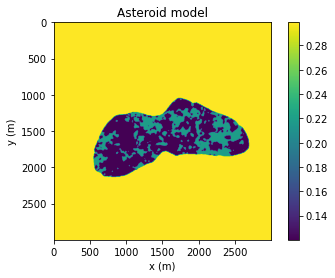

In [10]:
plt.imshow(np.rot90(my_array_vp,3))
plt.title('Asteroid model')
plt.colorbar(orientation='vertical')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

#plt.figure(figsize=(16, 6))

#plt.subplot(121)
#true_model.vp.T.plot()
#plt.subplot(122)
#true_model.rho.T.plot()

plt.show()

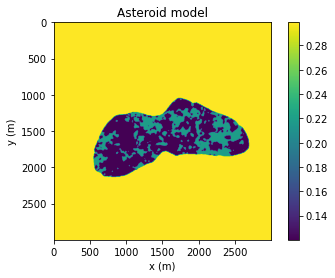

In [11]:
plt.imshow(np.rot90(my_array_vp,3))
plt.title('Asteroid model')
plt.colorbar(orientation='vertical')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

#plt.figure(figsize=(16, 6))

#plt.subplot(121)
#true_model.vp.T.plot()
#plt.subplot(122)
#true_model.rho.T.plot()

plt.show()

In [12]:
def my_model():
    nx, nz = 3000, 3000
    x = np.linspace(-4000, +4000, nx)
    y = np.linspace(-4000, +4000, nx)
    xx, yy = np.meshgrid(x, y, indexing = "ij")
    
    #put the array elements into the appropriate part of the model xarray structure
    ds = xr.Dataset ( data_vars= {"vp": (["x", "y"], my_array_vp),  "rho": (["x", "y"], my_array_rho),}, coords={"x": x, "y": y},)
    
    #Transform velocity to SI units (m/s).
    ds['vp'] *=10000

    return ds

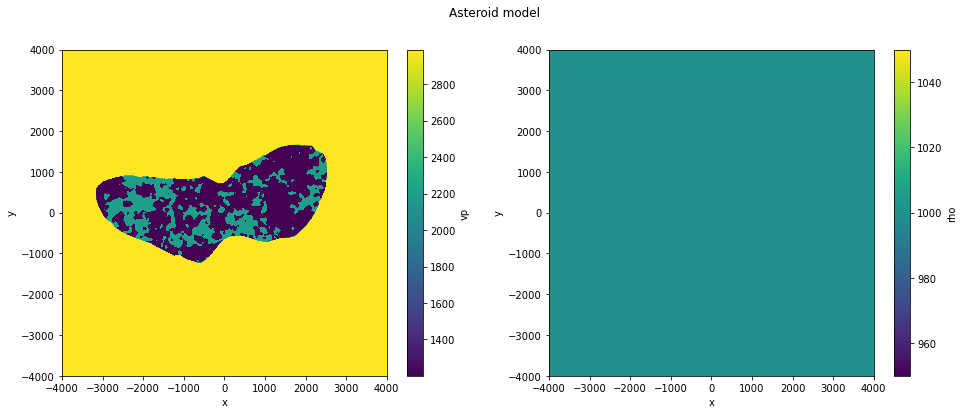

In [13]:
true_model = my_model()

# Plot the xarray dataset.
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("Asteroid model")
true_model.vp.T.plot()
plt.subplot(122)
true_model.rho.T.plot()
plt.suptitle("Asteroid model")
plt.show()

In [14]:
import pathlib
!rm -rf project
if pathlib.Path("project").exists():
    print("Opening existing project.")
    p = sn.Project(path="project")
else:
    print("Creating new project.")
    vm = sn.model.volume.cartesian.GenericModel(
        name="true_model_2", data=true_model
    )
    p = sn.Project.from_volume_model(path="project", volume_model=vm)

Creating new project.


In [15]:
wavelet=sn.simple_config.stf.Ricker(center_frequency=10.0)
mesh_frequency = 2 * wavelet.center_frequency

srcs = sn.simple_config.source.cartesian.ScalarPoint2D( 
     source_time_function=wavelet, x=-100.0, y=3500.0, f=1)


recs = sn.simple_config.receiver.cartesian.collections.RingPoint2D(
        x=0, y=0, radius=3500, count=380, fields=["phi"])
    
p += sn.EventCollection.from_sources(sources=srcs, receivers=recs)

[2021-02-03 19:18:27,544] INFO: A source for event `event_0000` has a source time function. Events in the project cannot have a source time function (they are frequency dependent). The source time function has thus been stripped.


In [16]:
from salvus.toolbox import toolbox

num_absorbing_layers = 10
absorbing_side_sets = ["x0", "x1", "y0", "y1"]

mesh = toolbox.mesh_from_xarray(
    model_order=4,
    data=true_model,
    slowest_velocity="vp",
    maximum_frequency=mesh_frequency,
    elements_per_wavelength=1.5,
    absorbing_boundaries=(absorbing_side_sets, num_absorbing_layers)) 

In [17]:
mesh

In [18]:
sim = config.simulation.Waveform (mesh=mesh,sources=srcs,receivers=recs)

In [19]:
sim.output.point_data.format = "hdf5"

In [20]:
# Save the volumetric wavefield for visualization purposes.
sim.output.volume_data.format = "hdf5"
sim.output.volume_data.filename = "New_model_vm.h5"
sim.output.volume_data.fields = ["phi"]
sim.output.volume_data.sampling_interval_in_time_steps = 10

In [21]:
sim.validate()

In [22]:
sim

In [23]:
wsc = sn.WaveformSimulationConfiguration(end_time_in_seconds=6.0)
#print(wsc)

In [24]:
ec = sn.EventConfiguration(
    waveform_simulation_configuration=wsc,
    wavelet=sn.simple_config.stf.Ricker(center_frequency=10.0),
)


p += sn.SimulationConfiguration(
    name="true_model_new",
    elements_per_wavelength=1.5,
    tensor_order=4,
    max_frequency_in_hertz=mesh_frequency,
    model_configuration=sn.ModelConfiguration(
        background_model=None, volume_models="true_model_2"
    ),
    # Potentially event dependent settings.
    event_configuration=ec,
)

In [25]:
p.simulations.launch(
    simulation_configuration="true_model_new",
    events=p.events.get_all(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=1,

)

[2021-02-03 19:20:35,594] INFO: Creating mesh. Hang on.
[2021-02-03 19:20:45,586] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2102031920178858_eef6531853@local


1

In [26]:
p.simulations.query(block=True)

VBox()

True

In [27]:
p.simulations.get_mesh("true_model_new")

In [28]:
true_data = p.waveforms.get(
    data_name="true_model_new", events=p.events.get_all()
)

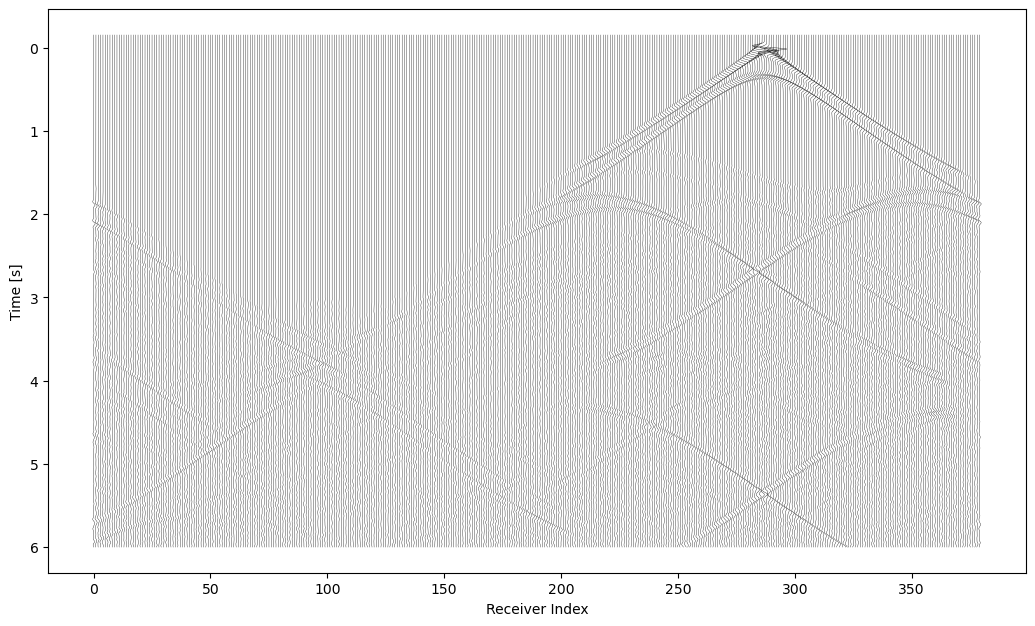

In [30]:
true_data[0].plot(component="A", receiver_field="phi")